<a href="https://colab.research.google.com/github/felipeeduardor/Departamento-de-M-dico/blob/main/Departamento_M%C3%A9dico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Departamento de Médico**

# **Importação de Bibliotecas**

In [24]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# carregar base de imagens
xray_directory = '/content/drive/MyDrive/Departamento médico/Dataset'

In [4]:
os.listdir(xray_directory)

['.DS_Store', '2', '3', '1', '0']

In [5]:
Image_generator = ImageDataGenerator(rescale=1/255)

In [6]:
train_generator =  Image_generator.flow_from_directory(batch_size=40, directory=xray_directory,
                                                       shuffle=True, target_size=(256,256),
                                                       class_mode='categorical', subset='training')

Found 532 images belonging to 4 classes.


In [7]:
133 * 4

532

In [8]:
532/40

13.3

In [9]:
train_images, train_labels = next(train_generator)

In [10]:
train_images.shape

(40, 256, 256, 3)

In [11]:
train_labels

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]],

In [12]:
#covid19- 1 0 0 0
#Normal - 0 1 0 0
#viral  - 0 0 1 0
#Bacterial - 0 0 0 1
labels_names = {0:'Covid-19',1:'Normal',2:'Pneunomia viral',3:'Pneunomia bacterial'}

# **Visualização de dados**

In [13]:
np.arange(0, 36)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35])

In [14]:
np.argmax(train_labels[0])

2

In [15]:
labels_names[1]

'Normal'

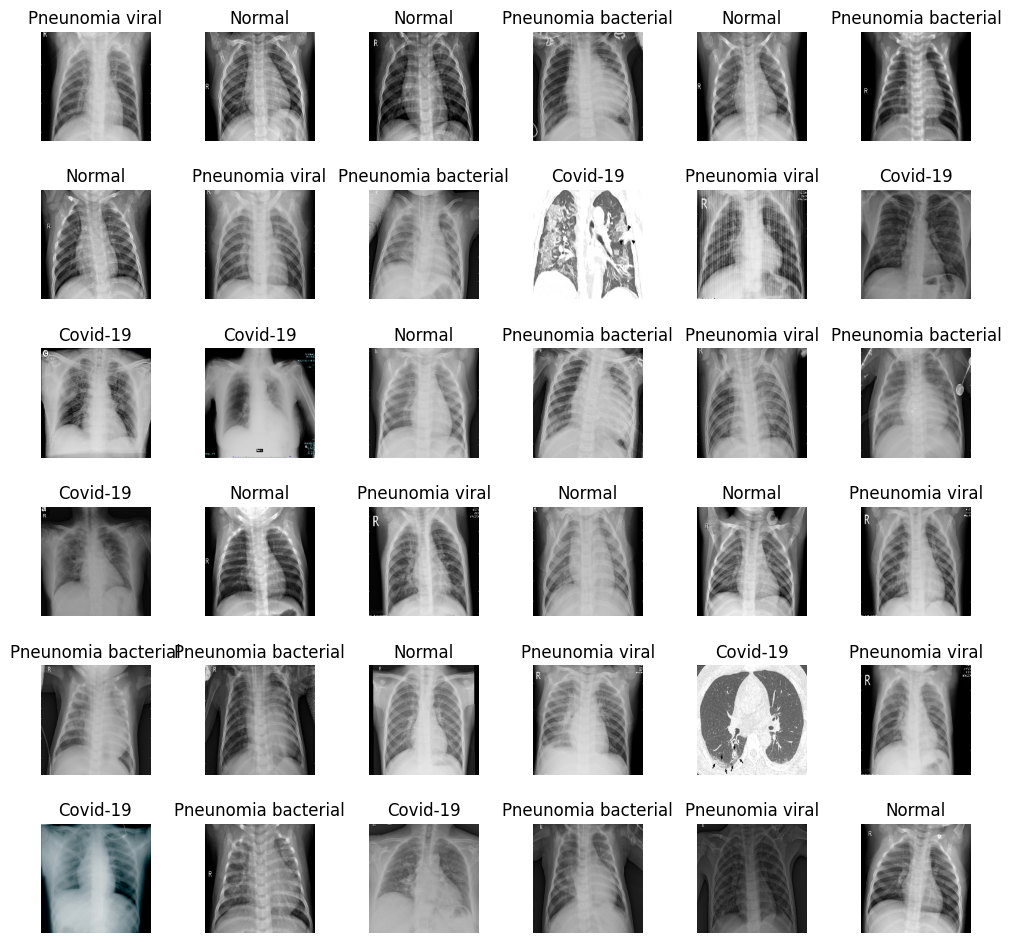

In [16]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
axes = axes.ravel()
for i in np.arange(0, 36):
   axes[i].imshow(train_images[i])
   axes[i].set_title(labels_names[np.argmax(train_labels[i])])
   axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

# **Carregamento da rede neural com pesos pré-treinados**

In [17]:
base_model = ResNet50(weights='imagenet',include_top=False,
                      input_tensor = Input(shape=(256,256,3)))

94765736/94765736 [==============================] - 0s 0us/step


In [18]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [19]:
len(base_model.layers)

175

# **Construção e treinamento do modelo de deep learning**

In [20]:
head_model = base_model.output
head_model = AveragePooling2D()(head_model)
head_model = Flatten()(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(256, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(4, activation = 'softmax')(head_model)

In [21]:
model = Model(inputs = base_model.input, outputs = head_model)

In [28]:
#model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay=1e-6),
             # metrics = ['accuracy'])

In [29]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4),
            metrics = ['accuracy'])

In [30]:
checkpointer = ModelCheckpoint(filepath='Weights.hdf5')

In [31]:
train_generator = Image_generator.flow_from_directory(batch_size= 4, directory=xray_directory,
                                                      shuffle = True, target_size=(256,256),
                                                      class_mode = 'categorical',subset='training')

Found 532 images belonging to 4 classes.


In [32]:
history = model.fit_generator(train_generator, epochs= 10, callbacks=[checkpointer])

<ipython-input-32-655a195048d1>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs= 10, callbacks=[checkpointer])


Epoch 1/10
133/133 [==============================] - ETA: 0s - loss: 2.9341 - accuracy: 0.3440

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


133/133 [==============================] - 592s 4s/step - loss: 2.9341 - accuracy: 0.3440
Epoch 2/10
133/133 [==============================] - 564s 4s/step - loss: 1.3562 - accuracy: 0.5508
Epoch 3/10
133/133 [==============================] - 561s 4s/step - loss: 1.0298 - accuracy: 0.6447
Epoch 4/10
133/133 [==============================] - 559s 4s/step - loss: 0.8610 - accuracy: 0.7162
Epoch 5/10
133/133 [==============================] - 566s 4s/step - loss: 0.7286 - accuracy: 0.7519
Epoch 6/10
133/133 [==============================] - 552s 4s/step - loss: 0.6679 - accuracy: 0.7744
Epoch 7/10
133/133 [==============================] - 567s 4s/step - loss: 0.5134 - accuracy: 0.8214
Epoch 8/10
133/133 [==============================] - 566s 4s/step - loss: 0.6129 - accuracy: 0.8177
Epoch 9/10
133/133 [==============================] - 551s 4s/step - loss: 0.5540 - accuracy: 0.8195
Epoch 10/10
133/133 [==============================] - 552s 4s/step - loss: 0.4831 - accuracy: 0.8553


# Avaliação da rede neural

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

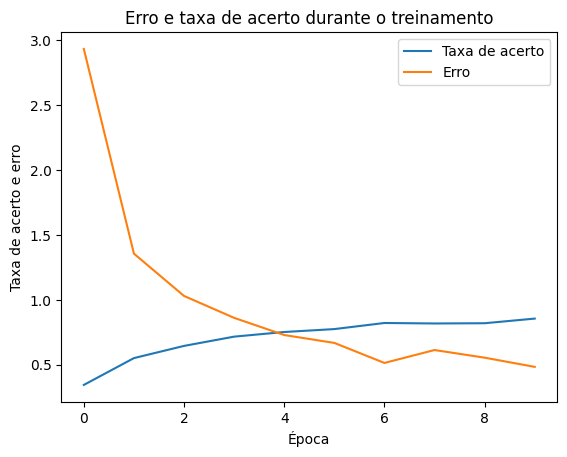

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('Erro e taxa de acerto durante o treinamento')
plt.xlabel('Época')
plt.ylabel('Taxa de acerto e erro')
plt.legend(['Taxa de acerto','Erro']);

In [35]:
test_directory ='/content/drive/MyDrive/Departamento médico/Test'

In [36]:
os.listdir(test_directory)

['3', '2', '0', '1']

In [37]:
test_gen = ImageDataGenerator(rescale=1/255)
test_generator = test_gen.flow_from_directory(batch_size = 40, directory = test_directory,
                                              shuffle = False, target_size = (256,256),
                                              class_mode = 'categorical')

Found 40 images belonging to 4 classes.


In [38]:
evaluate = model.evaluate_generator(test_generator)

<ipython-input-38-fff1a6b05c9b>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(test_generator)


In [39]:
evaluate

[1.3240032196044922, 0.7250000238418579]

In [40]:
len(os.listdir(test_directory))

4

In [41]:
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory, str(i))):
    #print(os.listdir(os.path.join(test_directory, str(i))))
    img = cv2.imread(os.path.join(test_directory, str(i), item))
    img = cv2.resize(img, (256, 256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

1/1 [==============================] - 0s 250ms/step


In [42]:
print(prediction)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 2, 1, 1, 0, 2, 1, 0, 1, 3, 1, 0, 3, 3, 3, 3, 3, 3, 1]


In [43]:
print(original)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [44]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [45]:
accuracy_score(original,prediction)

0.725

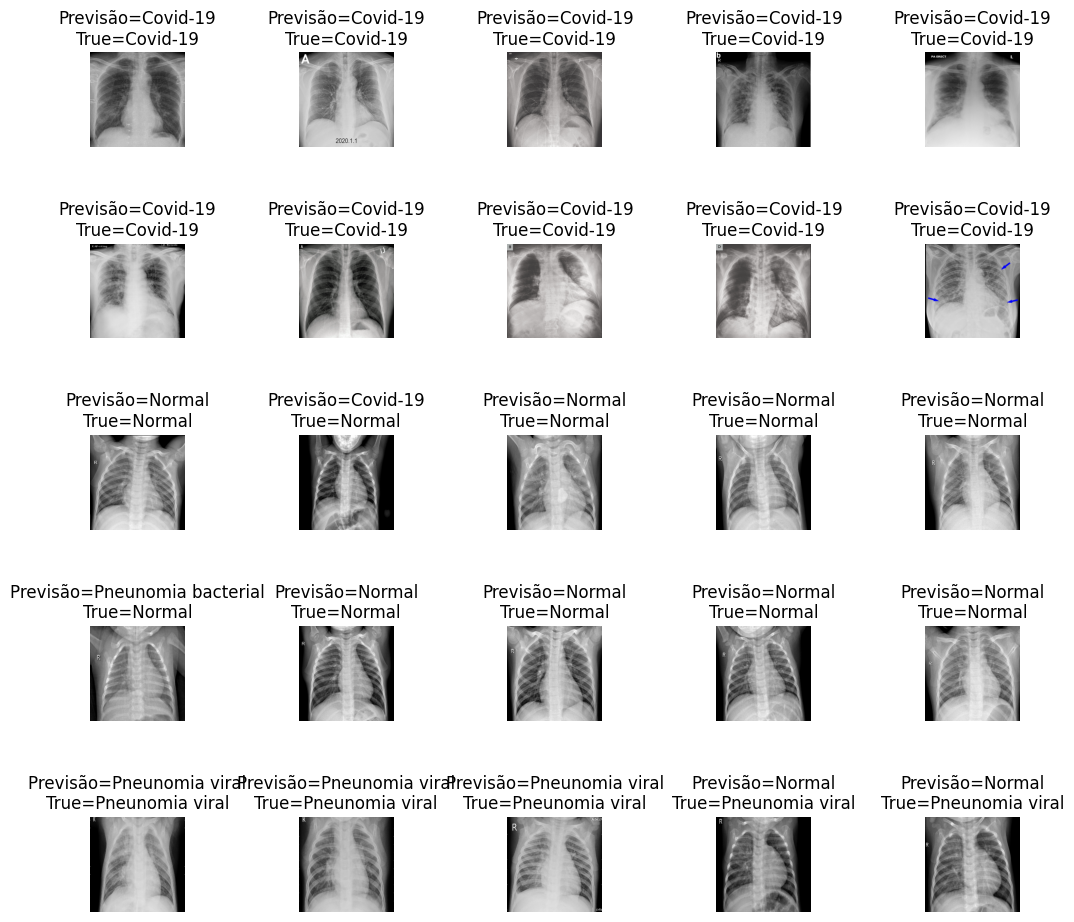

In [46]:
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
axes = axes.ravel()
for i in np.arange(0, 25):
   axes[i].imshow(image[i])
   axes[i].set_title('Previsão={}\nTrue={}'.format(str(labels_names[prediction[i]]), str(labels_names[original[i]])))
   axes[i].axis('off')
   plt.subplots_adjust(wspace=1.2)

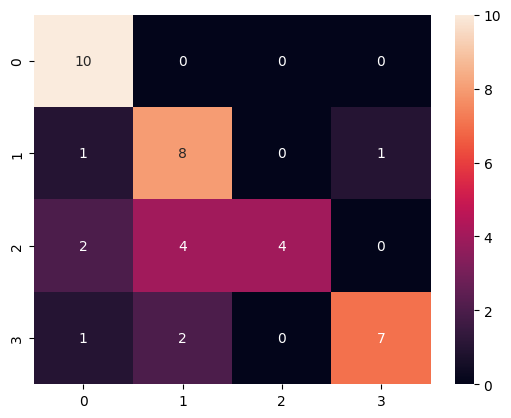

In [47]:
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot=True);

In [48]:
print(classification_report(original, prediction))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       0.57      0.80      0.67        10
           2       1.00      0.40      0.57        10
           3       0.88      0.70      0.78        10

    accuracy                           0.73        40
   macro avg       0.79      0.73      0.71        40
weighted avg       0.79      0.72      0.71        40



# **Classificação de somente uma imagem**



In [49]:
from keras.models import load_model
model_loaded = load_model('Weights.hdf5')

In [50]:
model_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [55]:
img = cv2.imread('/content/drive/MyDrive/Departamento médico/Test/0/1-s2.0-S0929664620300449-gr2_lrg-b.jpg')

In [56]:
img, img.shape

(array([[[ 44,  44,  44],
         [  1,   1,   1],
         [  1,   1,   1],
         ...,
         [255, 255, 255],
         [253, 253, 253],
         [254, 254, 254]],
 
        [[ 46,  46,  46],
         [  2,   2,   2],
         [  1,   1,   1],
         ...,
         [255, 255, 255],
         [253, 253, 253],
         [254, 254, 254]],
 
        [[ 45,  45,  45],
         [  1,   1,   1],
         [  0,   0,   0],
         ...,
         [255, 255, 255],
         [254, 254, 254],
         [254, 254, 254]],
 
        ...,
 
        [[ 44,  44,  44],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[ 44,  44,  44],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[ 44,  44,  44],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [255, 255, 255],
  

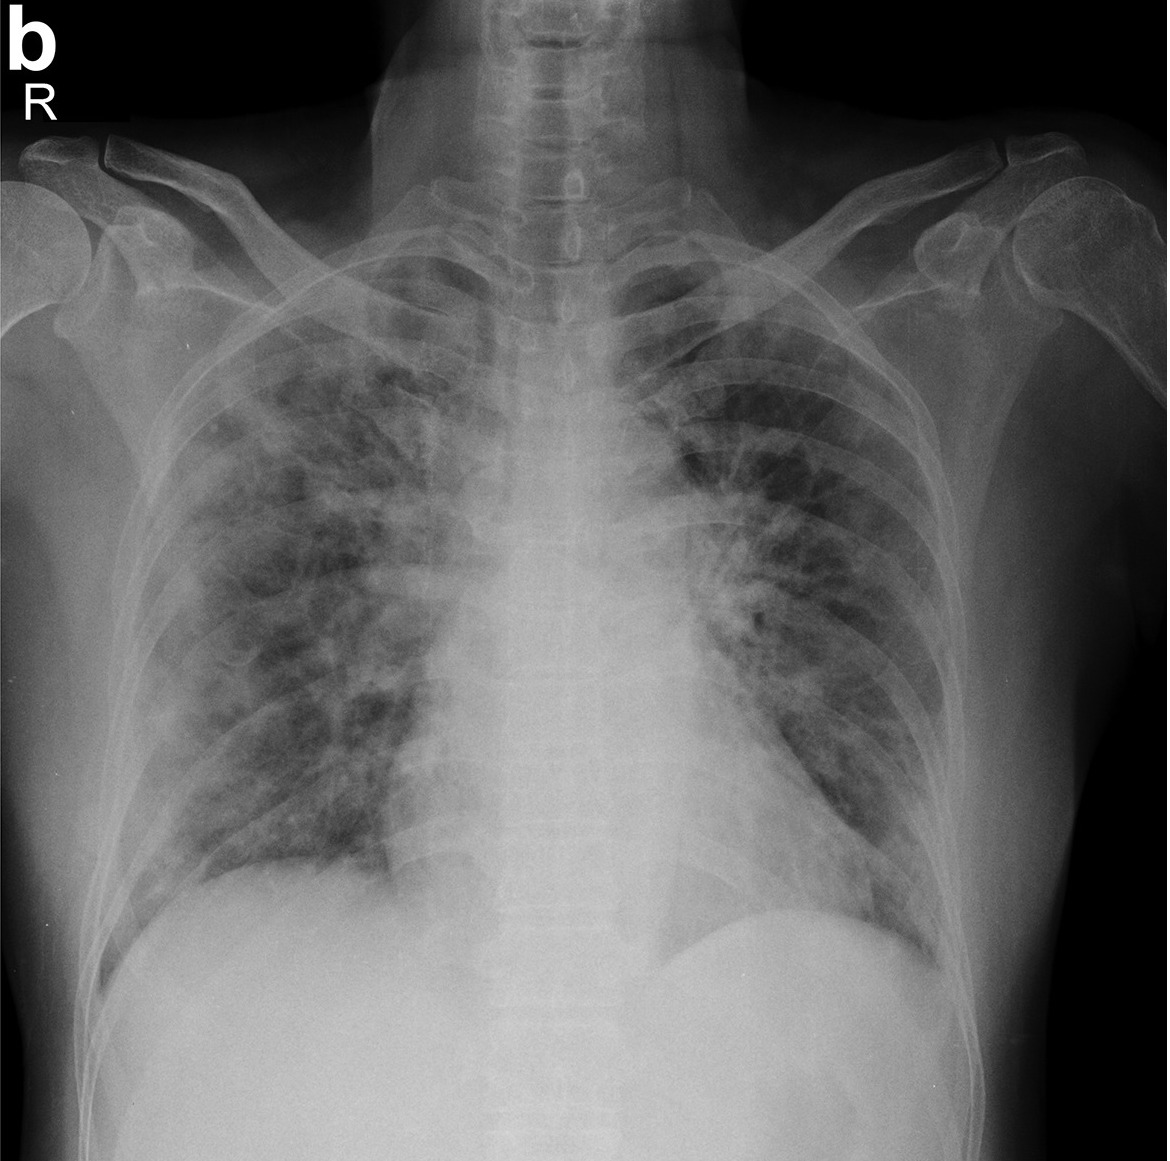

In [57]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

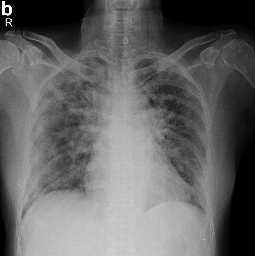

In [58]:
img = cv2.resize(img, (256, 256))
cv2_imshow(img)

In [59]:
img = img / 255
img

array([[[0.        , 0.        , 0.        ],
        [0.00392157, 0.00392157, 0.00392157],
        [0.01568627, 0.01568627, 0.01568627],
        ...,
        [0.        , 0.        , 0.        ],
        [0.00784314, 0.00784314, 0.00784314],
        [1.        , 1.        , 1.        ]],

       [[0.        , 0.        , 0.        ],
        [0.00392157, 0.00392157, 0.00392157],
        [0.98823529, 0.98823529, 0.98823529],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [1.        , 1.        , 1.        ]],

       [[0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        [0.99607843, 0.99607843, 0.99607843],
        ...,
        [0.        , 0.        , 0.        ],
        [0.00392157, 0.00392157, 0.00392157],
        [1.        , 1.        , 1.        ]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

In [60]:
img.shape

(256, 256, 3)

In [61]:
img = img.reshape(-1, 256, 256, 3)
img.shape

(1, 256, 256, 3)

In [62]:
predict = model_loaded(img)
predict

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[1.0000000e+00, 3.0372338e-14, 1.0007545e-17, 4.4313281e-18]],
      dtype=float32)>

In [63]:
predict2 = np.argmax(predict)
predict2

0

In [64]:
labels_names[predict2], predict[0][predict2]

('Covid-19', <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)